# Variational Quantum Algorithms in Q\#

## Abstract

In this sample, we will explore how the rich classical control provided by Q# can be used to efficiently write out variational quantum algorithms. In particular, we'll focus on the example of the _variational quantum eigensolver_, also known as VQE.

## Preamble

$
    \renewcommand{\ket}[1]{\left|#1\right\rangle}
$

In [1]:
from itertools import product
import qutip as qt
import qsharp

qsharp.init(project_root="SPSA")

Q# initialized with configuration: {'targetProfile': 'unrestricted', 'languageFeatures': None, 'manifest': '{\n  "dependencies": {\n    "Chemistry": {\n      "path": "../../../library/chemistry"\n    }\n  }\n}\n', 'projectRoot': 'file:///Users/swernli/Programming/qsharp/samples/chemistry/SPSA'}

For Q# code embedded in this notebook, it will be helpful to open a few namespaces before we proceed.

In [ ]:
%%qsharp
import Std.Arrays.*;
import Std.Convert.*;
import Std.Diagnostics.*;
import Std.Random.*;
import Std.Math.*;

## Introducing the Variational Quantum Eigensolver

In variational quantum algorithms, rather than performing all of our computation on the quantum device itself, we use a quantum program to estimate some quantity, then use a classical optimizer to find inputs to our quantum program that minimize or maximize that quantity. That is, rather than thinking of classical computation purely as a pre-processing or post-processing step, our computation uses both classical and quantum computation together.

> **💡 TIP:** We could also consider using classical computation while qubits are still alive, rather than returning an estimate to a classical optimizer. This approach is indeed very useful, for instance in iterative phase estimation. For this sample, however, we'll focus on the variational case.


For example, consider the problem of finding the _ground state energy_ of a given operator $H$, often called a _Hamiltonian_. The ground state energy of $H$ is defined as its smallest eigenvalue $E_0$, as the Hamiltonian represents the possible energy configurations of a given physical system.

As stated, even though this is a minimization, we need to know the eigenvalues of $H$ to make any progress. It's pretty straightforward to rephrase the problem in terms of arbitrary states, however. In particular, the expectation value $\left\langle H \right\rangle H = \left\langle \psi | H | \psi \right\rangle$ must be at least as large as $E_0$. To see this, we can expand the expectation value in terms of the eigenvectors $\{\ket{\phi_i}\}$ of $H$, such that $H\ket{\phi_i} = E_i$.

Since the decomposition of $H$ into eigenvectors gives us a basis, we know that $\left\langle \phi_i | \phi_j \right\rangle$ is zero whenever $i \ne j$, allowing us to expand $\ket{\psi}$ into the eigenbasis of $H$ as $\ket{\psi} = \sum_i \alpha_i \ket{\phi_i}$ for some complex coefficients $\{\alpha_i\}$. Using this decomposition, we can expand the expectation $\left\langle \psi | H | \psi \right\rangle$ in terms of the eigenvalues of $H$:

$$
\begin{aligned}
    \left\langle \psi | H | \psi \right\rangle
        & = \sum_i |\alpha_i|^2 \left\langle \phi_i | H | \phi_i \right\rangle \\
        & = \sum_i |\alpha_i|^2 \left\langle \phi_i | E_i \phi_i \right\rangle \\
        & = \sum_i |\alpha_i|^2 E_i.
\end{aligned}
$$

Since each $|\alpha_i|^2$ is nonnegative, and since $\sum_i |\alpha_i|^2 = 1$, the above gives us that
$$
    E_0 = \min_i E_i \le \left\langle \psi | H | \psi \right\rangle \le \max_i E_i.
$$

Thus, we can rephrase the original problem as a minimization not just over eigenstates, but of all arbitrary states,
$$
    E_0 = \min_{\ket{\psi}} \left\langle \psi | H | \psi \right\rangle,
$$
where the minimum is achieved when $\ket{\psi} = \ket{\phi_0}$.

Using this rephrasing, the _variational quantum eigensolver_ algorithm is just the variational algorithm that we get by using a classical optimizer to find $\min_{\ket{\psi}} \left\langle \psi | H | \psi \right\rangle$. In pseudocode:

```
operation FindMinimumEigenvalue {
    Pick an initial guess |ψ⟩.
    until target accuracy reached {
        Estimate E = ⟨ψ | H | ψ⟩ using a quantum operation.
        Use a classical optimizer to pick the next |ψ⟩.
    }
    Return the minimum E that we found and the state |ψ⟩ that achieved that minimum.
}
```

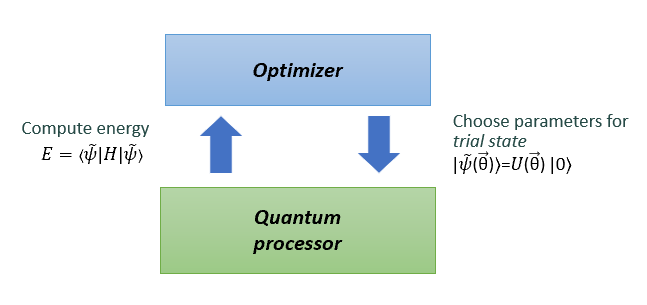

To turn the above pseudocode into a real quantum program, we still need to figure out two things:

- How to estimate $\left\langle \psi | H | \psi \right\rangle$ for a given state $\ket{\psi}$.
- How to optimize over all quantum states $\ket{\psi}$.

In the rest of this sample, we'll see how to do each of these, and how you can use Q# to write a VQE implementation.

## Estimating expectation values of $H$

Before proceeding to see how to estimate $\left\langle \psi | H | \psi \right\rangle$, however, it helps to consider what that expectation value _is_. To do so, let's consider a concrete example of a two-qubit Hamiltonian, using QuTiP to construct a Python object representing $H$.

In [3]:
H = qt.Qobj([
    [-2, 0, 0, 3],
    [0, 7, 0, 1],
    [0, 0, -4, 0],
    [3, 1, 0, -1]
], dims=[[2, 2]] * 2)
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-2.  0.  0.  3.]
 [ 0.  7.  0.  1.]
 [ 0.  0. -4.  0.]
 [ 3.  1.  0. -1.]]

Here, `H` is a Python object representing the 4 × 4 matrix $H$. We can use the `eigenstates` method provided by QuTiP to quickly find the eigenvalues and eigenvectors of $H$:

In [4]:
H.eigenstates()

(array([-4.57776672, -4.        ,  1.43800535,  7.13976137]),
 array([Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.75726547]
         [ 0.05620122]
         [ 0.        ]
         [-0.65068458]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [0.]
         [1.]
         [0.]]                                                                      ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.65152827]
         [-0.13424187]
         [-0.        ]
         [ 0.74665256]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.04538633]
         [0.9893536 ]
         [0.        ]
         [0.13

In particular, we can use the `min` function provided by Python to minimize over the eigenvalues of $H$ and find its ground state $\ket{\phi_0}$.

In [5]:
min_energy, ground_state = min(zip(*H.eigenstates()), key=lambda eig: eig[0])
min_energy, ground_state

(-4.57776672447103,
 Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
 Qobj data =
 [[ 0.75726547]
  [ 0.05620122]
  [ 0.        ]
  [-0.65068458]])

Here, `ground_state` represents the eigenvector $\ket{\phi_0}$ corresponding to the smallest eigenvalue $E_0$ of $H$. By the above argument, we would expect that $\left\langle \phi_0 | H | \phi_0 \right\rangle = E_0$. We can check that using QuTiP as well:

In [6]:
(ground_state.dag() * H * ground_state)

(-4.57776672447103+0j)

What's going on here? Effectively, for any operator $O$ such that $O^{\dagger} = O$, expressions like $\left\langle \psi | O | \psi \right\rangle$ represent another way of thinking about quantum measurement. In particular, if we think of the eigenvalues of $O$ as labels for its corresponding various eigenvectors, then $\left\langle \psi | O | \psi \right\rangle$ is the average label that we get when we measure $O$ in the basis of its eigenvectors.

> **💡 TIP:** This way of thinking about quantum measurement is sometimes called the _observable framework_, with $O$ being called an _observable_. We avoid using this terminology here to avoid confusion, however, as the expectation value of $O$ cannot be observed directly, but only inferred from repeated measurements.

For example, if $O = Z$, then the eigenstate $\ket{0}$ is labeled by its eigenvalue $+1$, while $\ket{1}$ is labeled by $-1$. The expectation value $\left\langle \psi | Z | \psi \right\rangle$ is then the probability of getting a `Zero` minus the probability of getting a `One`.

More generally, finding the expectation value of an arbitrary Pauli operator for an arbitrary input state is straightforward using the `Measure` and `EstimateFrequencyA` operations.

In [7]:
%%qsharp

import Chemistry.JordanWigner.JordanWignerVQE.EstimateFrequency;

operation EstimatePauliExpectation(pauli : Pauli[], preparation : (Qubit[] => Unit is Adj), nShots : Int) : Double {
    return 2.0 * EstimateFrequency(
        preparation,
        Measure(pauli, _),
        Length(pauli),
        nShots
    ) - 1.0;
}

Here, we've represented the state $\ket{\psi}$ by an operation `preparation` that prepares that state. Since each Pauli operator other than the identity operator has exactly two eigenvalues, $+1$ and $-1$, corresponding to `Zero` and `One` respectively, we can turn the estimate of the probability $p_0$ with which `Measure(pauli, _)` returns `Zero` into an expectation value $p_0 - p_1 = p_0 - (1 - p_0) = 2 p_0 - 1$.

For example, doing nothing prepares the state $\ket{0}$, so we get an expectation value of $1$:

In [8]:
%%qsharp

operation EstimateExpectationOfZero() : Double {
    return EstimatePauliExpectation(
        [PauliZ],
        qs => I(qs[0]),
        100
    );
}

In [9]:
qsharp.code.EstimateExpectationOfZero()

1.0

Similarly, using `X` to prepare $\ket{1}$ gives us an expectation of $-1$, while using `H` to prepare $\ket{+} = \frac{1}{\sqrt{2}} (\ket{0} + \ket{1})$ gives an expectation value of $0$.

In [10]:
%%qsharp

operation EstimateExpectationOfOne() : Double {
    return EstimatePauliExpectation(
        [PauliZ],
        ApplyToEachCA(X, _),
        100
    );
}

In [11]:
qsharp.code.EstimateExpectationOfOne()

-1.0

In [12]:
%%qsharp

operation EstimateExpectationOfPlus() : Double {
    return EstimatePauliExpectation(
        [PauliZ],
        ApplyToEachCA(H, _),
        100
    );
}

In [13]:
qsharp.code.EstimateExpectationOfPlus()

-0.040000000000000036

Note that in practice, we won't always get exactly 0 due to using a finite number of measurements.

In any case, to recap, it's easy to use a quantum program to find $\left\langle \psi | H | \psi \right\rangle$ in the special case that $H$ is a multi-qubit Pauli operator. What about the more general case? The linearity of quantum mechanics saves us again! It turns out that we can expand the expectation of any other operator in terms of expectations of Pauli operators. To see how that works, suppose that $H = 2 Z - X$.

In [14]:
2 * qt.sigmaz() - qt.sigmax()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 2. -1.]
 [-1. -2.]]

We can expand $\left\langle \psi | (2Z - X) | \psi \right\rangle$ by using linearity:

$$
    \left\langle \psi | (2Z - X) | \psi \right\rangle = 2 \left\langle \psi | Z | \psi \right\rangle - \left\langle \psi | X | \psi \right\rangle.
$$

Each of the terms in this expansion is something that we can estimate easily using our `EstimatePauliExpectation` operation from above.

In [15]:
%%qsharp

operation EstimateExpectation(terms : (Double, Pauli[])[], preparation : (Qubit[] => Unit is Adj), nShots : Int) : Double {
    mutable sum = 0.0;
    for (coefficient, pauli) in terms {
        sum += coefficient * EstimatePauliExpectation(
            pauli, preparation, nShots
        );
    }
    return sum;
}

With this, we almost have everything we need to estimate expectations $\left\langle \psi | H | \psi \right\rangle$. We just need a way of finding the decomposition of $H$ into Pauli operators. Thankfully, QuTiP can help here as well.

In [16]:
def pauli_to_qobj(pauli):
    if pauli == qsharp.Pauli.I:
        return qt.Qobj(qt.identity(2))
    elif pauli == qsharp.Pauli.X:
        return qt.Qobj(qt.sigmax())
    elif pauli == qsharp.Pauli.Y:
        return qt.Qobj(qt.sigmay())
    elif pauli == qsharp.Pauli.Z:
        return qt.Qobj(qt.sigmaz())

In [17]:
def pauli_basis(n_qubits):
    scale = 2 ** n_qubits
    return [
        tuple([P, qt.tensor(*(pauli_to_qobj(p) for p in P)) / scale])
        for P in product([qsharp.Pauli.I, qsharp.Pauli.X, qsharp.Pauli.Y, qsharp.Pauli.Z], repeat=n_qubits)
        ]

In [18]:
def expand_in_pauli_basis(op):
    return [
        (coeff.real, list(label))
        for label, coeff in [
            tuple([label, (P.dag() * op).tr()])
            for label, P in pauli_basis(n_qubits=len(op.dims[0]))
        ]
        if abs(coeff) >= 1e-10
    ]

For example, we can use the two functions above to find that $H = -3 𝟙 \otimes Z + 0.5 X \otimes 𝟙 + 1.5 X \otimes X - 0.5 X \otimes Z - 1.5 Y \otimes Y + 2.5 Z \otimes 𝟙 - 1.5 Z \otimes Z$:

In [19]:
H_decomposition = expand_in_pauli_basis(H)
H_decomposition

[(-3.0, [Pauli.I, Pauli.Z]),
 (0.5, [Pauli.X, Pauli.I]),
 (1.5, [Pauli.X, Pauli.X]),
 (-0.5, [Pauli.X, Pauli.Z]),
 (-1.5, [Pauli.Y, Pauli.Y]),
 (2.5, [Pauli.Z, Pauli.I]),
 (-1.5, [Pauli.Z, Pauli.Z])]

This decomposition is exactly what we need to pass as `terms` above. For example, to estimate the expectation of the $\ket{++}$ state, $\left\langle ++ | H | ++ \right\rangle$, we can pass `terms` to `EstimateExpectation`. In doing so, we'll use the name "energy" for our new operation, pointing to that expectation values of Hamiltonian operators $H$ represent the average energy of a system given the quantum state of that system.

In [20]:
%%qsharp

operation EstimateEnergyOfPlus(terms : (Double, Pauli[])[]) : Double {
    return EstimateExpectation(
        terms,
        ApplyToEachCA(H, _),
        100
    );
}

In [21]:
qsharp.code.EstimateEnergyOfPlus(H_decomposition)

1.9399999999999995

This is pretty far from the minimum $E_0$ we found from the eigenvalue decomposition above, so in the next part we'll see one more trick we can use to write our VQE implementation.

## Preparing ansatz states

Recall that our goal is to use a classical optimizer to find the minimum energy $E_0$ of some Hamiltonian operator $H$:
$$
    E_0 = \min_{\ket{\psi}} \left\langle \psi | H | \psi \right\rangle.
$$

In practice, we can't reasonably optimize over all possible quantum states $\ket{\psi}$, so that the above optimization problem is intractable for all but the smallest systems. Instead, we note that we can find an upper-bound for $E_0$ by solving a simpler problem. Suppose that there is a set $A$ of states that are easier to prepare. Then,
$$
    E_0 = \min_{\ket{\psi}} \left\langle \psi | H | \psi \right\rangle \le \min_{\ket{\psi} \in A} \left\langle \psi | H | \psi \right\rangle.
$$

If we choose $A$ carefully so that $\ket{\phi_0} \in A$, this inequality will be tight. More often, however, $\ket{\phi_0}$ won't actually be in $A$, but will be close to some other state in $A$, giving us a reasonable approximation to $E_0$.

We say that $A$ is our _ansatz_ for running VQE; in this way, $A$ plays a similar role to a model in an ML training loop, representing what we believe to be a reasonable set of guesses for $\ket{\phi_0}$. One can get pretty involved with their choice of ansatz, but for this sample, we'll choose a really simple one, and set $A$ to be those states that can be prepared by a small number of Pauli rotations.

In [22]:
%%qsharp

operation PrepareAnsatz(axes : Pauli[][], angles : Double[], register : Qubit[]) : Unit is Adj {
    for i in IndexRange(angles) {
        Exp(axes[i], angles[i], register);
    }
}

Our minimization $\min_{\ket{\psi} \in A} \left\langle \psi | H | \psi \right\rangle$ is now a minimization over `angles` for some fixed list of Pauli rotation axes. Using `DumpMachine` and `DumpRegister`, we can visualize how this ansatz works for a few different choices of parameters `angles`, convincing ourselves that $A$ contains enough interesting states to find $E_0$.

In [23]:
%%qsharp

operation DumpAnsatz(axes : Pauli[][], angles : Double[]) : Unit {
    use register = Qubit[Length(angles)];
    within {
        PrepareAnsatz(axes, angles, register);
    } apply {
        DumpRegister(register);
    }
}

In [24]:
ansatz_axes = [[qsharp.Pauli.Z, qsharp.Pauli.Z], [qsharp.Pauli.X, qsharp.Pauli.Y]]

In [25]:
qsharp.code.DumpAnsatz(ansatz_axes, [1.2, 1.9])

<table class="qs-stateTable">
  <style>
    .qs-stateTable thead tr {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
    .qs-stateTable th {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody {
      pointer-events: none;
    }
    .qs-stateTable tbody td {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody td span {
      display: inline-block;
    }
    .qs-stateTable tbody tr:nth-child(even) {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
  </style>
  <thead>
    <tr>
      <th>Basis State<br />(|𝜓₁…𝜓ₙ⟩)</th>
      <th>Amplitude</th>
      <th>Measurement Probability</th>
      <th colspan="2">Phase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
  <td>
    <span>|00⟩</span>
  </td>
  <td>
    <span>−0.1171−0.3013𝑖</span>
  </td>
  <td>
    <progress max="100" value="10.45161440427916"></progress>
    <span>10.4516%</span>
  </td>
  <td style="transform: rotate(-1.9416rad)">↑</td>
  <td>
    <span>-1.9416</span>
  </td>
</tr>
<tr>
  <td>
    <span>|11⟩</span>
  </td>
  <td>
    <span>−0.3429−0.8820𝑖</span>
  </td>
  <td>
    <progress max="100" value="89.54838559572084"></progress>
    <span>89.5484%</span>
  </td>
  <td style="transform: rotate(-1.9416rad)">↑</td>
  <td>
    <span>-1.9416</span>
  </td>
</tr>

  </tbody>
</table>


In [26]:
qsharp.code.DumpAnsatz(ansatz_axes, [1.2, -0.7])

<table class="qs-stateTable">
  <style>
    .qs-stateTable thead tr {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
    .qs-stateTable th {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody {
      pointer-events: none;
    }
    .qs-stateTable tbody td {
      text-align: left;
      border: none;
    }
    .qs-stateTable tbody td span {
      display: inline-block;
    }
    .qs-stateTable tbody tr:nth-child(even) {
      background-color: var(
        --vscode-list-hoverBackground,
        var(--jp-layout-color1, inherit)
      );
    }
  </style>
  <thead>
    <tr>
      <th>Basis State<br />(|𝜓₁…𝜓ₙ⟩)</th>
      <th>Amplitude</th>
      <th>Measurement Probability</th>
      <th colspan="2">Phase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
  <td>
    <span>|00⟩</span>
  </td>
  <td>
    <span>0.2771+0.7129𝑖</span>
  </td>
  <td>
    <progress max="100" value="58.49835714501206"></progress>
    <span>58.4984%</span>
  </td>
  <td style="transform: rotate(1.2000rad)">↑</td>
  <td>
    <span>1.2000</span>
  </td>
</tr>
<tr>
  <td>
    <span>|11⟩</span>
  </td>
  <td>
    <span>0.2334+0.6004𝑖</span>
  </td>
  <td>
    <progress max="100" value="41.50164285498795"></progress>
    <span>41.5016%</span>
  </td>
  <td style="transform: rotate(1.2000rad)">↑</td>
  <td>
    <span>1.2000</span>
  </td>
</tr>

  </tbody>
</table>


At this point, it's helpful to write some new operations that directly estimate the energy of a state given a parameterization of our ansatz, rather than an opaque operation that prepares the state.

In [27]:
%%qsharp

operation EstimateEnergyAtAnsatz(terms : (Double, Pauli[])[], axes : Pauli[][], angles : Double[], nShots : Int) : Double {
    return EstimateExpectation(
        terms,
        PrepareAnsatz(axes, angles, _),
        nShots
    );
}

In [28]:
qsharp.code.EstimateEnergyAtAnsatz(
    H_decomposition,
    ansatz_axes,
    [1.2, 1.9],
    1000
)

0.7390000000000003

## Running VQE in Q\#

Using this new operation, we have something that looks much more like classical optimization problems that we may be used to! Indeed, we can simply use our favorite optimization algorithm to pick different values for `angles` until we find a good approximation for $E_0$. In this sample, we'll use the _SPSA algorithm_ to optimize `angles`, as this algorithm works especially well for objective functions that have some amount of noise, such as that added by taking a finite number of shots above.

We won't go through the details of SPSA here, but if you're interested to learn more, check out [`SPSA.qs`](./SPSA/src/SPSA.qs) in this folder to see how we implemented SPSA in Q#.

In [29]:
%%qsharp

import SPSA.*;

operation FindMinimumEnergy(terms : (Double, Pauli[])[], axes : Pauli[][], initialGuess : Double[], nShots : Int) : (Double[], Double) {
    let oracle = EstimateEnergyAtAnsatz(terms, axes, _, nShots);
    let options = DefaultSpsaOptions();
    return FindMinimumWithSpsa(
        oracle,
        initialGuess,
        options
    );
}

In [30]:
qsharp.code.FindMinimumEnergy(H_decomposition, ansatz_axes, [1.2, 1.9], 1000)

Iteration 1:

    obj([1.0999999999999999, 2.0]) = 1.1939999999999995

    obj([1.3, 1.7999999999999998]) = 0.25900000000000034

Iteration 2:

    obj([5.043238648643683, -1.9432386486436832]) = -3.138

    obj([4.856761351356317, -1.756761351356317]) = -2.083

Iteration 3:

    obj([9.084878774549992, -5.80588383667864]) = -4.171000000000001

    obj([8.90588383667864, -5.984878774549993]) = -3.568

Iteration 4:

    obj([10.535640921734934, -4.355121689493698]) = 0.757000000000001

    obj([10.36177200971693, -4.528990601511703]) = -0.07900000000000018

Iteration 5:

    obj([8.553949974759709, -6.336812636468924]) = -1.702

    obj([8.383955805601582, -6.5068068056270505]) = -0.6140000000000003

Iteration 6:

    obj([11.097417268504492, -3.9602378039359896]) = 1.4259999999999997

    obj([10.930524807292644, -3.7933453427241397]) = 1.1429999999999998

Iteration 7:

    obj([10.432605046730536, -3.295425582162034]) = -1.021

    obj([10.596919245566806, -3.459739780998304]) = -0.22099999999999986

Iteration 8:

    obj([8.721082781473008, -1.7460163408815679]) = -2.064000000000001

    obj([8.883195805450072, -1.583903316904506]) = -1.0920000000000005

Iteration 9:

    obj([7.222224052110989, -3.4050710091614342]) = -0.4760000000000002

    obj([7.062028113193143, -3.244875070243587]) = -1.3249999999999997

Iteration 10:

    obj([5.311727845447455, -1.653075068593994]) = -1.5130000000000003

    obj([5.470228111543549, -1.4945748024978993]) = -0.4889999999999999

Iteration 11:

    obj([3.744449775267648, -3.0633713279524746]) = -2.4690000000000003

    obj([3.901431586088974, -3.2203531387738003]) = -1.5310000000000001

Iteration 12:

    obj([2.4885394395173024, -1.8074609922021285]) = -2.3770000000000002

    obj([2.3329311639951906, -1.6518527166800168]) = -1.5099999999999998

Iteration 13:

    obj([4.123518366011016, -3.442439918695842]) = -0.09000000000000008

    obj([3.969163005265829, -3.2880845579506555]) = -0.9939999999999993

Iteration 14:

    obj([2.797839071673697, -2.1167606243585233]) = -3.904

    obj([2.644634733149064, -1.9635562858338904]) = -3.2169999999999996

Iteration 15:

    obj([3.635425375809424, -2.9543469284942505]) = -3.1829999999999994

    obj([3.7875658545441793, -3.1064874072290056]) = -2.2909999999999995

Iteration 16:

    obj([2.4604292880354066, -1.779350840720233]) = -2.1570000000000005

    obj([2.6115812808670293, -1.9305028335518557]) = -3.0879999999999996

Iteration 17:

    obj([3.838960914575619, -3.1578824672604453]) = -1.8079999999999998

    obj([3.688731610781285, -3.0076531634661112]) = -2.878

Iteration 18:

    obj([2.729021712127196, -2.047943264812022]) = -3.569

    obj([2.8783862407562566, -2.197307793441083]) = -4.287999999999999

Iteration 19:

    obj([3.289955839527876, -2.6088773922127024]) = -4.449000000000001

    obj([3.438506942923287, -2.757428495608113]) = -4.083

Iteration 20:

    obj([2.62494808322752, -1.9438696359123462]) = -3.3240000000000003

    obj([2.4771645770228794, -1.7960861297077058]) = -2.428

Iteration 21:

    obj([3.417129210089135, -2.5889937137135655]) = -4.404

    obj([3.270072161028739, -2.7360507627739614]) = -3.9350000000000005

Iteration 22:

    obj([3.5668971716627156, -2.439225752139985]) = -4.494

    obj([3.420529452636529, -2.5855934711661717]) = -4.356

Iteration 23:

    obj([3.8513765864502267, -2.154746337352474]) = -3.9999999999999996

    obj([3.705664531092227, -2.3004583927104734]) = -4.415

Iteration 24:

    obj([3.0719990233208585, -2.7890368472072855]) = -3.735

    obj([3.217086076595415, -2.934123900481842]) = -3.1500000000000004

Iteration 25:

    obj([2.3814949330501607, -2.0985327569365877]) = -3.7260000000000004

    obj([2.52598502078897, -2.243022844675397]) = -4.365

Iteration 26:

    obj([2.954317511810305, -2.671355335696732]) = -4.126

    obj([2.81039865934241, -2.527436483228837]) = -4.388

Iteration 27:

    obj([2.560155148540727, -2.277192972427154]) = -4.227

    obj([2.416783837871512, -2.133821661757939]) = -4.069

Iteration 28:

    obj([2.79396677547435, -2.511004599360777]) = -4.646

    obj([2.936812430378211, -2.653850254264638]) = -4.301

Iteration 29:

    obj([2.539000396034041, -2.398378494045976]) = -4.606

    obj([2.681340670159549, -2.256038219920468]) = -4.342

Iteration 30:

    obj([2.53489122838635, -2.402487661693667]) = -4.338

    obj([2.3930375019740335, -2.544341388105983]) = -4.519

([2.621354808572941, -2.316024081507076], -4.361)

In [31]:
min_energy

-4.57776672447103